In [ ]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List
import matplotlib.pyplot as plt
import scipy.sparse as scs
from numpy.linalg import norm

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression
import scipy
import math
import random
import sklearn
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ndcg_score



#Общая концепция:
Отобрать наиболее важные признаки, найти их веса и привести к виду,
подходящему для решения задачи ранжирования.



##1. Отбор признаков

In [137]:
import warnings
warnings.filterwarnings("ignore")

In [138]:
intern_task = pd.read_csv("intern_task.csv")
intern_task.head()

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
0,0,10,1.0,0.0,1.0,3.0,3.0,0.333333,0.0,0.333333,...,0.0,0.000000,0.454545,0.890238,8.655534,1.000000,0.077778,0.002222,1.0,0.333333
1,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.773976,23.130514,0.000000,0.027826,0.000430,44.0,14.666667
2,0,10,3.0,0.0,2.0,0.0,3.0,1.000000,0.0,0.666667,...,0.0,0.000000,0.000000,0.918308,13.351339,0.000000,0.014925,0.000104,22.0,7.333333
3,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.975355,18.240926,0.000000,0.053140,0.000255,8.0,2.666667
4,2,10,3.0,0.0,3.0,1.0,3.0,1.000000,0.0,1.000000,...,273.0,79.670665,0.200000,0.990119,31.786048,0.333333,0.046512,0.000307,24.0,8.000000


In [139]:
categorical_list = []      #разделим категориальные(если есть) и не категориальные признаки
numerical_list = []
for i in intern_task.columns.tolist():
    if intern_task[i].dtype=='object':
        categorical_list.append(i)
    else:
        numerical_list.append(i)
print('Number of categorical features:', len(categorical_list))
print('Number of numerical features:', len(numerical_list))

Number of categorical features: 0
Number of numerical features: 146


In [140]:
from sklearn.impute import SimpleImputer #заполним пропуски
intern_task[numerical_list] = SimpleImputer(missing_values=np.nan,
                                            strategy='median').fit_transform(intern_task [numerical_list])

In [141]:
X = intern_task.drop(['rank', 'query_id'], axis=1)
y = intern_task['rank']
feature_name = X.columns.tolist()

In [142]:
intern_task.isnull().sum().sum()#проверим, остались ли пропуски

0

In [143]:
from sklearn.ensemble import RandomForestClassifier #нужен для отбора признаков
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X, y)

RandomForestClassifier()

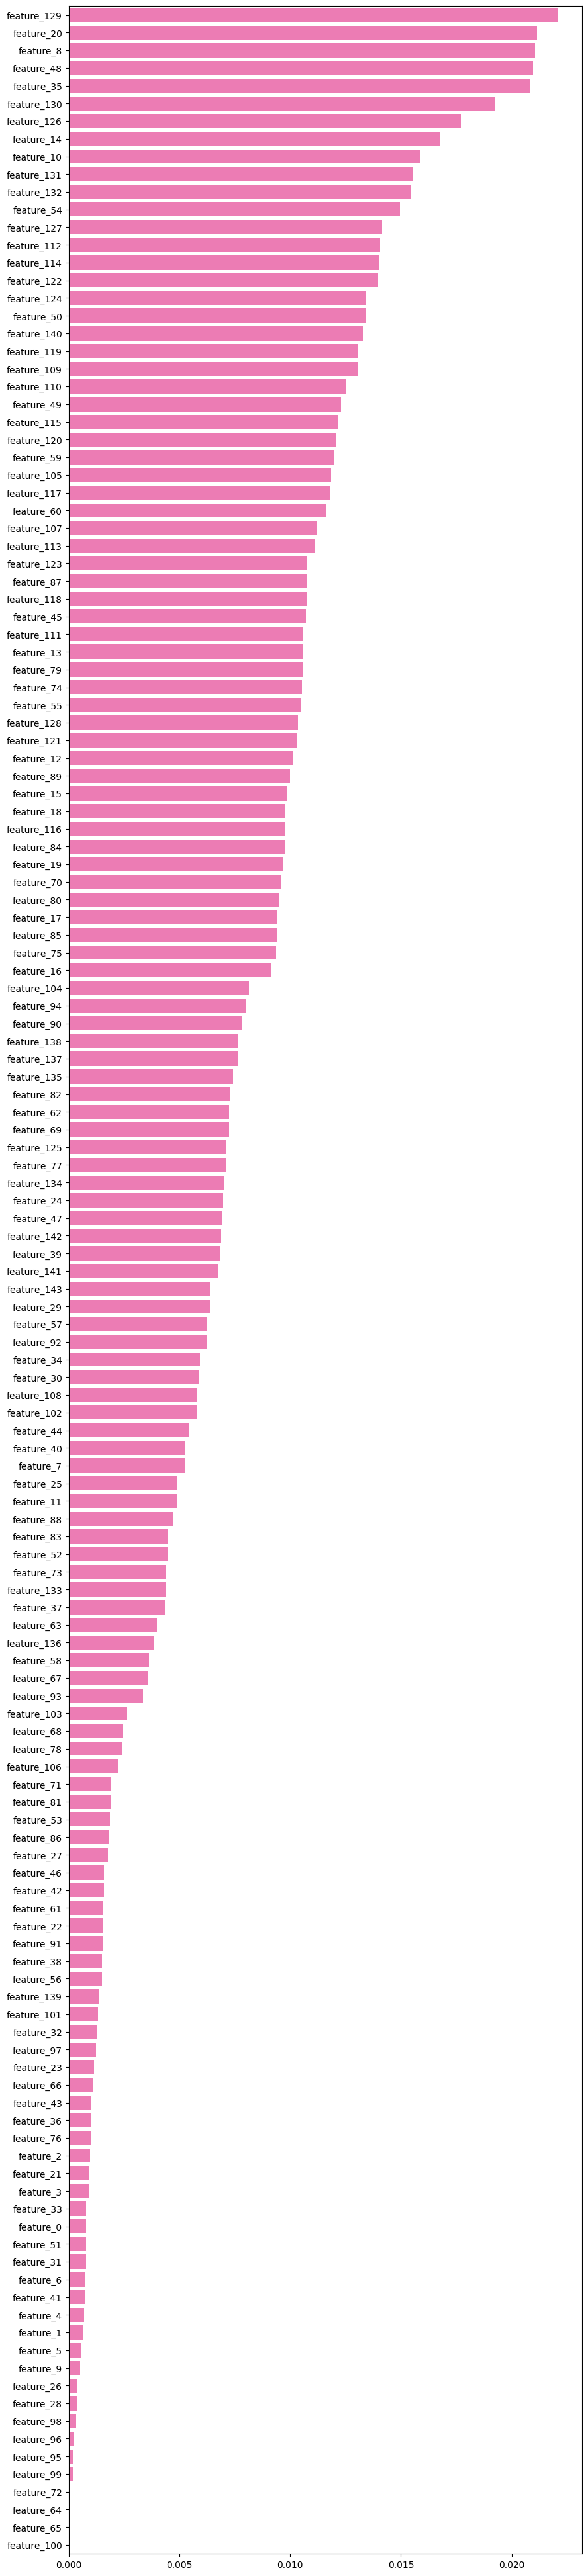

In [144]:
plot = sns.barplot(y=feature_name,  #диаграмма важности признаков
                   x=clf.feature_importances_,
                   order=np.array(feature_name)[np.argsort(clf.feature_importances_)][::-1], color ='hotpink'
                   )
plot.figure.set_size_inches(10, 50)

In [145]:
from sklearn.feature_selection import SelectFromModel #отберем лучшие признаки
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100),
                                      threshold='1.25*median')
embeded_rf_selector.fit(X, y)

SelectFromModel(estimator=RandomForestClassifier(), threshold='1.25*median')

In [146]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

57 selected features


In [147]:
X.loc[:,embeded_rf_feature]

,feature_8,feature_10,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,...,feature_123,feature_124,feature_126,feature_127,feature_128,feature_129,feature_130,feature_131,feature_132,feature_140
0,0.000000,10.0,9.0,11.0,30.0,8.198216,22.240604,18.240926,21.439961,8.194138,...,-6.122882,-8.437561,76.0,0.0,0.0,153.0,3866.0,17.0,104.0,0.077778
1,0.004251,557.0,7.0,11.0,575.0,8.198216,22.240604,18.240926,21.439961,8.194138,...,-26.827529,-11.848628,73.0,0.0,9.0,266.0,56137.0,5.0,2.0,0.027826
2,0.008501,522.0,6.0,8.0,536.0,8.198216,22.240604,18.240926,21.439961,8.194138,...,-26.827529,-14.353039,54.0,8.0,0.0,541.0,12621.0,11.0,11.0,0.014925
3,0.012752,59.0,5.0,5.0,69.0,8.198216,22.240604,18.240926,21.439961,8.194138,...,-26.827529,-9.208571,36.0,6.0,0.0,14687.0,40205.0,5.0,3.0,0.053140
4,0.017003,203.0,7.0,5.0,215.0,8.198216,22.240604,18.240926,21.439961,8.194138,...,-22.302319,-9.911815,21.0,1896.0,1.0,10577.0,34605.0,1.0,1.0,0.046512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235253,999.982997,1091.0,6.0,9.0,1111.0,27.896604,32.206631,31.723366,31.997173,27.894259,...,-2.877949,-6.019758,36.0,103.0,62.0,5131.0,65535.0,2.0,1.0,0.001350
235254,999.987248,1210.0,16.0,11.0,1237.0,27.896604,32.206631,31.723366,31.997173,27.894259,...,-2.877949,-4.740896,58.0,428.0,2.0,1940.0,54880.0,7.0,4.0,0.004850
235255,999.991499,439.0,19.0,12.0,470.0,27.896604,32.206631,31.723366,31.997173,27.894259,...,-2.877949,-6.258085,61.0,24242.0,27.0,6135.0,51819.0,2.0,4.0,0.001064
235256,999.995749,0.0,0.0,9.0,14.0,27.896604,32.206631,31.723366,31.997173,27.894259,...,-2.877949,-7.030938,42.0,100.0,0.0,3121.0,61234.0,49.0,6.0,0.000000


In [148]:
features = np.array(feature_name)[np.argsort(clf.feature_importances_)][::-1]
coefs = embeded_rf_selector.estimator_.feature_importances_

importance_coefs= pd.Series(coefs, index=features)

In [149]:
data = importance_coefs.loc[embeded_rf_feature]

In [150]:
fvloc =[]
for i in range(0, len(embeded_rf_feature)):
    fvloc.append(data[i])

In [151]:
datafeat = data.index.tolist()

In [152]:
datafeat

['feature_8',
 'feature_10',
 'feature_12',
 'feature_13',
 'feature_14',
 'feature_15',
 'feature_16',
 'feature_17',
 'feature_18',
 'feature_19',
 'feature_20',
 'feature_35',
 'feature_45',
 'feature_48',
 'feature_49',
 'feature_50',
 'feature_54',
 'feature_55',
 'feature_59',
 'feature_60',
 'feature_70',
 'feature_74',
 'feature_75',
 'feature_77',
 'feature_79',
 'feature_80',
 'feature_84',
 'feature_85',
 'feature_87',
 'feature_89',
 'feature_104',
 'feature_105',
 'feature_107',
 'feature_109',
 'feature_110',
 'feature_111',
 'feature_112',
 'feature_113',
 'feature_114',
 'feature_115',
 'feature_116',
 'feature_117',
 'feature_118',
 'feature_119',
 'feature_120',
 'feature_121',
 'feature_122',
 'feature_123',
 'feature_124',
 'feature_126',
 'feature_127',
 'feature_128',
 'feature_129',
 'feature_130',
 'feature_131',
 'feature_132',
 'feature_140']

In [153]:
df = intern_task[datafeat].copy()

In [154]:
df.head()

,feature_8,feature_10,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,...,feature_123,feature_124,feature_126,feature_127,feature_128,feature_129,feature_130,feature_131,feature_132,feature_140
0,0.000000,10.0,9.0,11.0,30.0,8.198216,22.240604,18.240926,21.439961,8.194138,...,-6.122882,-8.437561,76.0,0.0,0.0,153.0,3866.0,17.0,104.0,0.077778
1,0.004251,557.0,7.0,11.0,575.0,8.198216,22.240604,18.240926,21.439961,8.194138,...,-26.827529,-11.848628,73.0,0.0,9.0,266.0,56137.0,5.0,2.0,0.027826
2,0.008501,522.0,6.0,8.0,536.0,8.198216,22.240604,18.240926,21.439961,8.194138,...,-26.827529,-14.353039,54.0,8.0,0.0,541.0,12621.0,11.0,11.0,0.014925
3,0.012752,59.0,5.0,5.0,69.0,8.198216,22.240604,18.240926,21.439961,8.194138,...,-26.827529,-9.208571,36.0,6.0,0.0,14687.0,40205.0,5.0,3.0,0.053140
4,0.017003,203.0,7.0,5.0,215.0,8.198216,22.240604,18.240926,21.439961,8.194138,...,-22.302319,-9.911815,21.0,1896.0,1.0,10577.0,34605.0,1.0,1.0,0.046512


In [155]:
feauters_union = np.dot(df.to_numpy(), fvloc) #возьмем общую характеристику признаков с весами, это будет айтемом

In [156]:
intern_task['item'] = pd.Series(feauters_union)

In [157]:
intern_task.head()

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,item
0,0.0,10.0,1.0,0.0,1.0,3.0,3.0,0.333333,0.0,0.333333,...,0.000000,0.454545,0.890238,8.655534,1.000000,0.077778,0.002222,1.0,0.333333,4.468625
1,1.0,10.0,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.000000,0.000000,0.773976,23.130514,0.000000,0.027826,0.000430,44.0,14.666667,50.211864
2,0.0,10.0,3.0,0.0,2.0,0.0,3.0,1.000000,0.0,0.666667,...,0.000000,0.000000,0.918308,13.351339,0.000000,0.014925,0.000104,22.0,7.333333,23.828063
3,1.0,10.0,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.000000,0.000000,0.975355,18.240926,0.000000,0.053140,0.000255,8.0,2.666667,36.653253
4,2.0,10.0,3.0,0.0,3.0,1.0,3.0,1.000000,0.0,1.000000,...,79.670665,0.200000,0.990119,31.786048,0.333333,0.046512,0.000307,24.0,8.000000,55.261144


In [158]:
ratings = intern_task[['query_id','item', 'rank']].copy ()

In [159]:
ratings

,query_id,item,rank
0,10.0,4.468625,0.0
1,10.0,50.211864,1.0
2,10.0,23.828063,0.0
3,10.0,36.653253,1.0
4,10.0,55.261144,2.0
...,...,...,...
235253,29995.0,1512.128627,2.0
235254,29995.0,1512.525896,2.0
235255,29995.0,1735.220273,1.0
235256,29995.0,1478.273098,2.0


In [160]:
ratings.head().T

,0,1,2,3,4
query_id,10.000000,10.000000,10.000000,10.000000,10.000000
item,4.468625,50.211864,23.828063,36.653253,55.261144
rank,0.000000,1.000000,0.000000,1.000000,2.000000


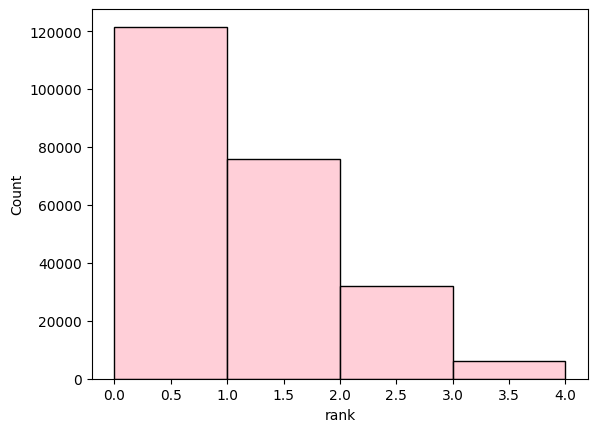

In [161]:
sns.histplot(data=ratings["rank"], binwidth=1, color='pink')
plt.show()

In [162]:
def rating_distribution(column: str) -> None:
    # Compute
    ratings_dist = ratings[column].value_counts(normalize=True).reset_index()
    ratings_dist.columns = [column, "num_ratings_percent"]
    print(ratings_dist.shape[0])
    step = 1 / (ratings_dist.shape[0]-1)

    ratings_dist[f"{column}_percent"] = np.arange(0, 1 + step, step) * 100
    print(ratings_dist[f"{column}_percent"] )
    ratings_dist["num_ratings_percent"] = (
        np.cumsum(ratings_dist["num_ratings_percent"]) * 100
    )

    # Plot
    fig, ax = plt.subplots()
    sns.lineplot(
        data=ratings_dist, x=f"{column}_percent", y="num_ratings_percent", ax=ax
    )
    ax.set_xlim(0, 100)
    ax.set_xticks(range(0, 101, 2))
    ax.set_title("Rating Distribution")
    plt.show()

235258
0           0.000000
1           0.000425
2           0.000850
3           0.001275
4           0.001700
             ...    
235253     99.998300
235254     99.998725
235255     99.999150
235256     99.999575
235257    100.000000
Name: item_percent, Length: 235258, dtype: float64


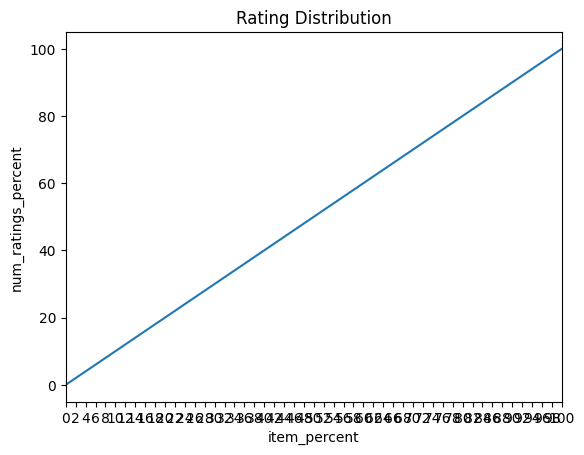

In [163]:
rating_distribution(column="item")

##2. Top-popular model


In [164]:
users_interactions_count_df = ratings.groupby(['query_id', 'item']).size().groupby('query_id').size()
print('# users: %d' % len(users_interactions_count_df))
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['query_id']]
print('# users with at least 5 interactions: %d' % len(users_with_enough_interactions_df))

# users: 2000
# users with at least 5 interactions: 1985


In [165]:
print('# of interactions: %d' % len(ratings))
interactions_from_selected_users_df = ratings.merge(users_with_enough_interactions_df,
               how = 'right',
               left_on = 'query_id',
               right_on = 'query_id')
print('# of interactions from users with at least 5 interactions: %d' % len(interactions_from_selected_users_df))


# of interactions: 235258
# of interactions from users with at least 5 interactions: 235214


In [166]:
def smooth_user_preference(x):
    return math.log(1+x, 2)

interactions_full_df = interactions_from_selected_users_df \
                    .groupby(['query_id', 'item'])['rank'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head(10)

# of unique user/item interactions: 235214


,query_id,item,rank
0,10.0,4.468625,0.000000
1,10.0,7.575254,0.000000
2,10.0,7.950416,0.000000
3,10.0,11.067900,0.000000
4,10.0,12.178524,1.000000
5,10.0,12.374500,0.000000
6,10.0,12.876754,1.000000
7,10.0,13.926618,0.000000
8,10.0,21.755112,1.584963
9,10.0,22.450388,1.000000


In [167]:
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['query_id'],
                                   test_size=0.20,
                                   random_state=42)

print('Interactions on Train set: %d' % len(interactions_train_df))
print('Interactions on Test set: %d' % len(interactions_test_df))

Interactions on Train set: 188171
Interactions on Test set: 47043


In [168]:
interactions_indexed_df = ratings.set_index('query_id')
interactions_train_indexed_df = interactions_train_df.set_index('query_id')
interactions_test_indexed_df = interactions_test_df.set_index('query_id')

In [169]:
interactions_indexed_df

,item,rank
query_id,,
10.0,4.468625,0.0
10.0,50.211864,1.0
10.0,23.828063,0.0
10.0,36.653253,1.0
10.0,55.261144,2.0
...,...,...
29995.0,1512.128627,2.0
29995.0,1512.525896,2.0
29995.0,1735.220273,1.0


In [170]:
def dcg_at_k(r, k, method=0): #https://gist.github.com/bwhite/3726239?permalink_comment_id=1989155
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.


def ndcg_at_k(r, k, method):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [171]:
def get_items_interacted(person_id, interactions_df):
    # Get the user's data and merge in the movie information.
    interacted_items = interactions_df.loc[person_id]['item']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [172]:
#Метрики
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100
import random

class ModelEvaluator:


    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_indexed_df)
        all_items = set(ratings['item'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, person_id): #берет элементы из теста
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['item']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['item'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['item'])])
        interacted_items_count_testset = len(person_interacted_items_testset)


        person_recs_df = model.recommend_items(person_id,
                                               items_to_ignore=get_items_interacted(person_id,
                                                                                    interactions_train_indexed_df),
                                               topn=10000000000) #ранжированный список рекомендации для конкретного запроса

        hits_at_5_count = 0
        hits_at_10_count = 0
        for item_id in person_interacted_items_testset:
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id,
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS,
                                                                          seed=item_id%(2**32)) #показываем какие айтемы не будут релевантны для запроса

            items_to_filter_recs = non_interacted_items_sample.union(set([item_id])) #соединяем текущий и нерелевантные айтемы

            #Фильтруем только рекомендации, которые либо текущие, либо нерелевантной для запроса выборкой
            valid_recs_df = person_recs_df[person_recs_df['item'].isin(items_to_filter_recs)]
            valid_recs = valid_recs_df['item'].values
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5) #проверяем текущий айтем на топ-n
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10


        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset) #Recall-количество взаимодействующих элементов, попавших в число рекомендуемых топ-n
                                                                              #при смешивании с набором нерелевантных айтемов
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)
        ndсg = ndcg_at_k(valid_recs, 5, 1)

        person_metrics = {'hits@5_count':hits_at_5_count,
                          'hits@10_count':hits_at_10_count,
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10,
                          "ndcg": ndсg}
        return person_metrics

    def evaluate_model(self, model):
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            person_metrics = self.evaluate_model_for_user(model, person_id)
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        #print('%d users' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)

        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        ndcg_5 = detailed_results_df['ndcg'].mean()

        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10,
                          "ndcg": ndcg_5}
        return global_metrics, detailed_results_df


model_evaluator = ModelEvaluator()

In [173]:
item_popularity_df = interactions_full_df.groupby('item')['rank'].sum().sort_values(ascending=False).reset_index()
item_popularity_df.head(10)

,item,rank
0,227.546477,2.321928
1,667.878983,2.321928
2,1473.119418,2.321928
3,760.779368,2.321928
4,473.528466,2.321928
5,736.392390,2.321928
6,655.485708,2.321928
7,1017.953069,2.321928
8,381.465023,2.321928
9,1473.141628,2.321928


In [174]:
class PopularityRecommender:

    MODEL_NAME = 'Popularity'

    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df


    def get_model_name(self):
        return self.MODEL_NAME

    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['item'].isin(items_to_ignore)] \
                               .sort_values('rank', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left',
                                                          left_on = 'item',
                                                          right_on = 'item')[['rank', 'item']]


        return recommendations_df



popularity_model = PopularityRecommender(item_popularity_df, ratings)

In [124]:
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

Evaluating Popularity recommendation model...

Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.04597701149425287, 'recall@10': 0.09545227386306847, 'ndcg': 0.23391460529953098}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,ndcg,_person_id
1,1,8,64,0.015625,0.125000,0.027448,310.0
11,0,0,53,0.000000,0.000000,0.041978,910.0
37,7,15,48,0.145833,0.312500,0.007406,1225.0
66,1,2,39,0.025641,0.051282,0.074688,820.0
38,2,4,39,0.051282,0.102564,0.109013,220.0
5,1,5,38,0.026316,0.131579,0.607272,1180.0
27,2,2,38,0.052632,0.052632,0.259949,370.0
65,0,0,36,0.000000,0.000000,0.076447,1315.0
55,2,4,36,0.055556,0.111111,0.626367,835.0
18,0,0,35,0.000000,0.000000,0.598897,730.0


##3. LightFM

In [175]:
!pip install lightfm

In [126]:
from lightfm import LightFM

In [176]:
ratings.head()

,query_id,item,rank
0,10.0,4.468625,0.0
1,10.0,50.211864,1.0
2,10.0,23.828063,0.0
3,10.0,36.653253,1.0
4,10.0,55.261144,2.0


In [177]:
re_baseline=ratings[['query_id','item','rank']]
re_baseline.describe()

,query_id,item,rank
count,235258.000000,2.352580e+05,235258.000000
mean,14828.413401,1.906471e+03,0.677869
std,8193.945170,3.143387e+04,0.830033
min,10.000000,1.884453e+00,0.000000
25%,8215.000000,4.278876e+02,0.000000
50%,14935.000000,7.948267e+02,0.000000
75%,21580.000000,1.162368e+03,1.000000
max,29995.000000,3.226355e+06,4.000000


In [129]:
!pip install scipy

In [63]:
from scipy.sparse import csr_matrix
from lightfm import cross_validation
X_topic_pivot=re_baseline.pivot_table(index = 'query_id',
                            values = 'rank',
                            columns='item',
                            aggfunc = {'rank':'mean'},
                            margins = True,
                            fill_value=0)
data_pivot=X_topic_pivot.reset_index()
pivot_train_np=data_pivot.to_numpy()
data_ds=pivot_train_np[:-1,1:-1].astype('int')
sData=csr_matrix(data_ds)
X_train_pivot, X_test_pivot=cross_validation.random_train_test_split(sData, test_percentage=0.2, random_state=None)

modelFM = LightFM(no_components=100,loss = 'warp')
modelFM.fit(X_train_pivot, epochs=100, num_threads=2)

In [130]:
from lightfm.evaluation import recall_at_k, precision_at_k


In [131]:
k=10
test_recall = recall_at_k(modelFM, sData, k=k).mean()
test_precision = precision_at_k(modelFM, sData, k=k).mean()
print(test_precision,test_recall)

0.93977267 0.36320494110420287


In [ ]:
k=10
test_recall = recall_at_k(modelFM, sData, k=k).mean()
test_precision = precision_at_k(modelFM, sData, k=k).mean()
print(test_precision,test_recall)

In [132]:
pred=modelFM.predict_rank(sData)
ar=pred.toarray()

In [133]:
prod_ids = re_baseline['item'].tolist()
timer_ids = re_baseline['query_id'].tolist()
ranks = re_baseline['rank'].tolist()

In [134]:
predict=[]
for i in range(ar.shape[0]):
  for m in range(ar.shape[1]):
    ar_list=[]
    if (ar[i,m]>0)&(ar[i,m]<11):
      ar_list.append(timer_ids[m])
      ar_list.append(prod_ids[m])
      ar_list.append(ar[i,m])
      ar_list.append(ranks[m])
      predict.append(ar_list)
predict_df=pd.DataFrame(predict,columns=['user_str','prod_id','pred_rank','rank'])
predict_df.head()


,user_str,prod_id,pred_rank,rank
0,10.0,78.663490,2.0,1.0
1,70.0,70.501344,9.0,2.0
2,130.0,64.493296,3.0,0.0
3,130.0,47.986104,7.0,0.0
4,190.0,50.692033,4.0,0.0


In [135]:
len(predict_df['pred_rank'].tolist()) == len(predict_df['rank'].tolist())

True

In [136]:
print('ndcg_5 score:', ndcg_score([predict_df['pred_rank'].values], [predict_df['rank'].values], k=5))

ndcg_5 score: 0.5098403808134256


In [ ]:
# Я использовала коллаборативный подход, хотя LightFM позволяет использовать и коллаборативный, и контентный,
# то есть использовать дополнительную информацию о пользователях из датасета.  Так как самая важная задача - это ранжирование, то сравнивая различные модели,
# лучше смотреть именно на качество ранжирования, а не на точность предсказания рейтинга, поэтому такая метрика как RMSE была бы неэффективной.